<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None
status
Normal                  0.308259
Depression              0.290406
Suicidal                0.200837
Anxiety                 0.073299
Bipolar                 0.054239
Stress                  0.050318
Personality disorder    0.022642
Name: count, dtype: float64
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


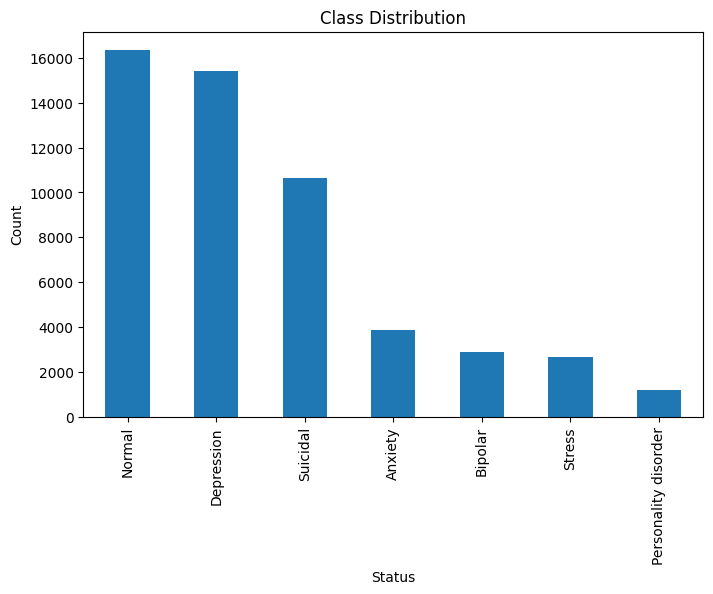

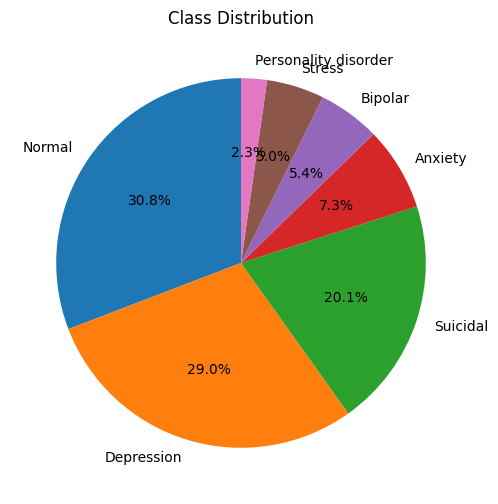

Summary statistics of word counts:
count    53043.000000
mean       112.393285
std        163.436684
min          1.000000
25%         15.000000
50%         61.000000
75%        147.500000
max       6300.000000
Name: word_count, dtype: float64


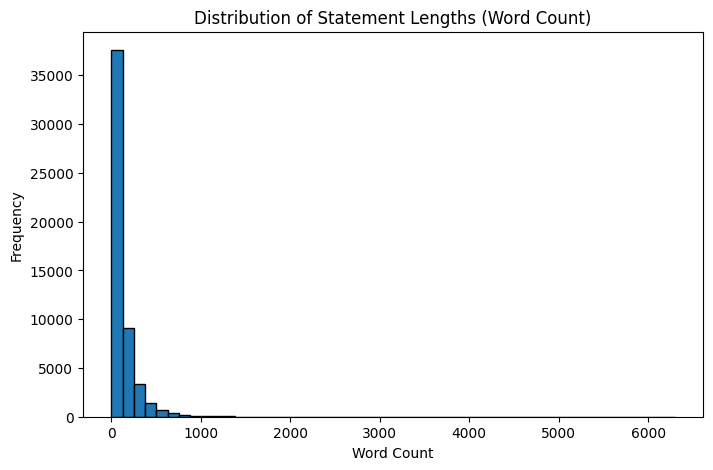

<Figure size 1000x600 with 0 Axes>

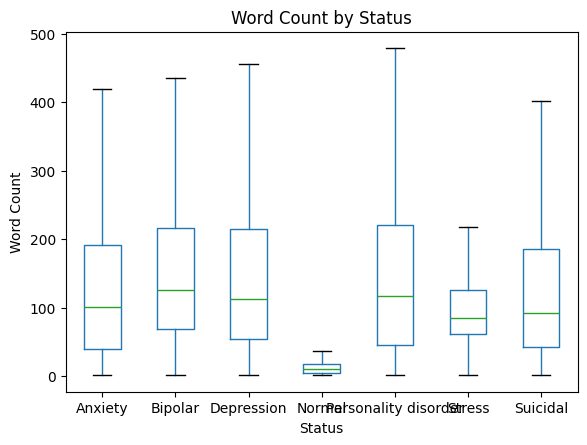

Short posts (<=2 words):
          statement   status
88          Anxious  Anxiety
284     restless eh  Anxiety
293             NaN  Anxiety
303    very nervous  Anxiety
319    Very worried  Anxiety
...             ...      ...
52838           NaN  Anxiety
52870           NaN  Anxiety
52936           NaN  Anxiety
53010           NaN  Anxiety
53031           NaN  Anxiety

[1253 rows x 2 columns]

Long posts (top 1% length):
                                               statement      status
7048   19 years old, male, from the Philippines. The ...  Depression
7078   First time posting here and feeling a bit ambi...  Depression
7085   I am sorry if you are already going through so...  Depression
7171   Not sure if this is the right place for this o...  Depression
7323   I feel like I have always had one sided friend...  Depression
...                                                  ...         ...
52818  every strange thing that’s happened in the las...     Anxiety
52847  I live with tw

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
from pathlib import Path 
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv(r"C:\Users\bhara\emotion-diary-ai\data\raw\Combined Data.csv")
print(df.info())

# -----------------------------
# EDA: Class distribution
# -----------------------------
value_counts = df['status'].value_counts()
print(value_counts / len(df))
print(value_counts)

# Bar plot
plt.figure(figsize=(8,5))
value_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

# Pie chart
plt.figure(figsize=(6,6))
value_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution")
plt.ylabel("")
plt.show()

# -----------------------------
# Word count per row
# -----------------------------
df['word_count'] = df['statement'].astype(str).apply(lambda x: len(str(x).split()))

print("Summary statistics of word counts:")
print(df['word_count'].describe())

# Histogram
plt.figure(figsize=(8,5))
plt.hist(df['word_count'], bins=50, edgecolor='black')
plt.title("Distribution of Statement Lengths (Word Count)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Boxplot
plt.figure(figsize=(10,6))
df.boxplot(column='word_count', by='status', grid=False, showfliers=False)
plt.title("Word Count by Status")
plt.suptitle("")
plt.xlabel("Status")
plt.ylabel("Word Count")
plt.show()

# Outliers
short_posts = df[df['word_count'] <= 2]
long_posts = df[df['word_count'] > df['word_count'].quantile(0.99)]
print("Short posts (<=2 words):")
print(short_posts[['statement','status']])
print("\nLong posts (top 1% length):")
print(long_posts[['statement','status']])

# -----------------------------
# Text Cleaning
# -----------------------------
df['clean_text'] = df['statement'].astype(str).str.lower()
df['clean_text'] = df['clean_text'].str.replace(r'[^\w\s]', '', regex=True)  # remove punctuation

# -----------------------------
# Extra Features
# -----------------------------
df['char_count'] = df['clean_text'].apply(len)
df['avg_word_len'] = df['char_count'] / df['word_count'].replace(0,1)

def stopword_ratio(text):
    words = text.split()
    if len(words) == 0:
        return 0
    stopwords = sum(1 for w in words if w in ENGLISH_STOP_WORDS)
    return stopwords / len(words)

df['stopword_ratio'] = df['clean_text'].apply(stopword_ratio)

def count_punctuations(text):
    return sum(1 for c in text if c in string.punctuation)

def count_exclamations(text):
    return text.count('!')

def count_questions(text):
    return text.count('?')

df['punct_count'] = df['statement'].astype(str).apply(count_punctuations)
df['exclam_count'] = df['statement'].astype(str).apply(count_exclamations)
df['question_count'] = df['statement'].astype(str).apply(count_questions)

# -----------------------------
# TF-IDF Features
# -----------------------------
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=df.index)

# -----------------------------
# Bag-of-Words (optional)
# -----------------------------
# bow = CountVectorizer(max_features=1000, stop_words='english')
# bow_matrix = bow.fit_transform(df['clean_text'])
# bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow.get_feature_names_out(), index=df.index)

# -----------------------------
# Combine Features
# -----------------------------
feature_df = pd.concat([
    df[['statement','status','word_count','char_count','avg_word_len','stopword_ratio',
        'punct_count','exclam_count','question_count']],
    tfidf_df
], axis=1)

print("Feature matrix shape:", feature_df.shape)
print(feature_df.head())

# -----------------------------
# Save processed data
# -----------------------------
processed_path = Path(r"C:\Users\bhara\emotion-diary-ai\data\processed\combined_data_clean.csv")
processed_path.parent.mkdir(parents=True, exist_ok=True)

feature_df.to_csv(processed_path, index=False)

print(f"✅ Processed data saved at {processed_path}")
